In [35]:
import os
import re
import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
import warnings, gc
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot,iqr
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
# from yellowbrick.classifier import ClassPredictionError

## EDA

In [2]:
df= pd.read_csv("credit_risk_dataset.csv")

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
def categorize_columns(dataframe, categorical_threshold=10, cardinality_threshold=20):
    # Identify categorical columns
    categorical_columns = dataframe.select_dtypes(include= ['object']).columns.tolist()

    # Identify numerical columns
    numerical_columns = dataframe.select_dtypes(exclude= ['object']).columns.tolist()

    # Identify numerical columns with low cardinality
    low_cardinality_numerical = [col for col in numerical_columns if dataframe[col].nunique() < categorical_threshold]

    # Identify categorical columns with high cardinality
    high_cardinality_categorical = [col for col in categorical_columns if dataframe[col].nunique() > cardinality_threshold]

    # Combine categorical columns and low-cardinality numerical columns
    selected_categorical_columns = list(set(categorical_columns + low_cardinality_numerical) - set(high_cardinality_categorical))

    
    return selected_categorical_columns, high_cardinality_categorical, numerical_columns

selected_cat_cols, high_card_cat_cols, selected_num_cols = categorize_columns(df)


In [5]:
df= df.drop_duplicates()

df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


Since we would still have ~28K observations after dropping the rows with null values, we go ahead and drop those

In [7]:
df= df.dropna()
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

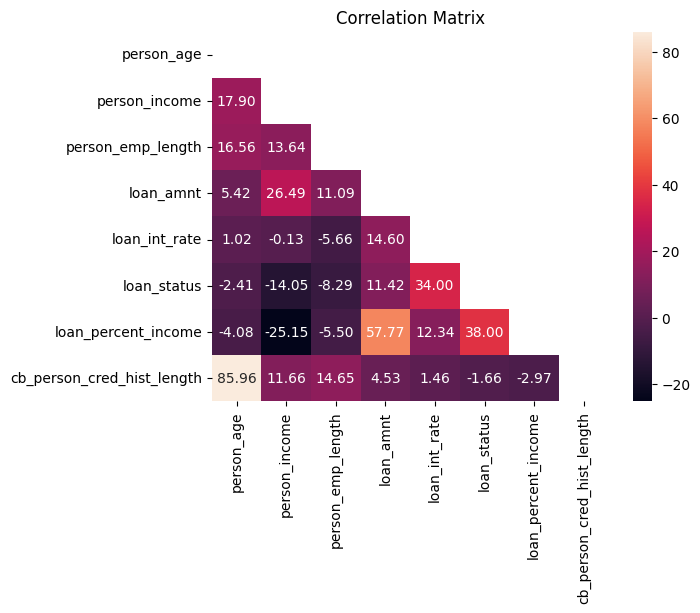

['cb_person_cred_hist_length']

In [8]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])
    
    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Correlation Matrix')
        plt.show()
    
    return drop_list


high_correlated_cols(df, plot=True)


In [9]:
def get_label_distribution(df, target_column):
    target_values= df[target_column].value_counts(normalize= True)
    target_labels = df[target_column].unique()
    plt.pie(target_values,labels=target_labels)

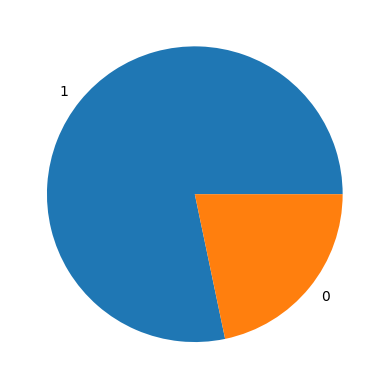

In [10]:
get_label_distribution(df,target_column="loan_status")

### Checking for outliers

In [11]:

def outlier_thresholds(dataframe, column, lower_quantile=0.10, upper_quantile=0.90):
    values = dataframe[column].values
    quantile_one = np.quantile(values, lower_quantile)
    quantile_three = np.quantile(values, upper_quantile)
    interquantile_range = iqr(values)
    upper_limit = quantile_three + 1.5 * interquantile_range
    lower_limit = quantile_one - 1.5 * interquantile_range
    return lower_limit, upper_limit

def check_outlier(dataframe, col_name):
    lower_limit, upper_limit = outlier_thresholds(dataframe, col_name)
    return any((dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit))

In [12]:
outlier_columns= []
for col in selected_num_cols:
    if check_outlier(df,col):
        print(f"{col} has outliers")
        outlier_columns.append(col)


person_age has outliers
person_income has outliers
person_emp_length has outliers
loan_amnt has outliers
loan_percent_income has outliers
cb_person_cred_hist_length has outliers


In [13]:
def handle_outlier(dataframe, column):
    lower_limit, upper_limit = outlier_thresholds(dataframe,column)
    dataframe.loc[(dataframe[column]<lower_limit, column)] = lower_limit
    dataframe.loc[(dataframe[column]>upper_limit, column)] = upper_limit

In [14]:
for col in outlier_columns:
    handle_outlier(df,col)

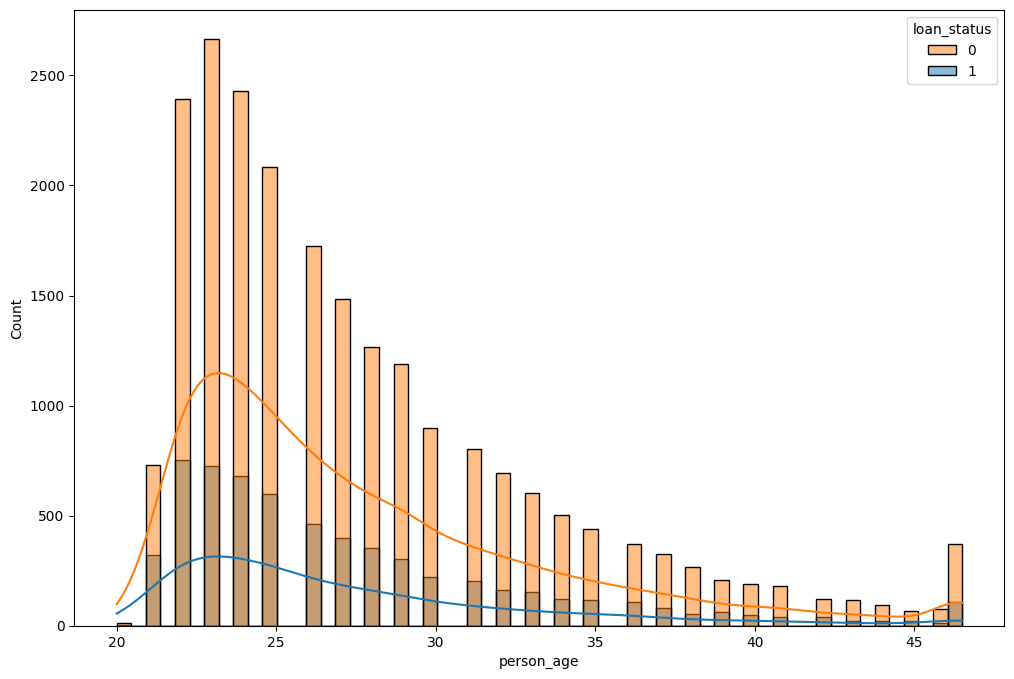

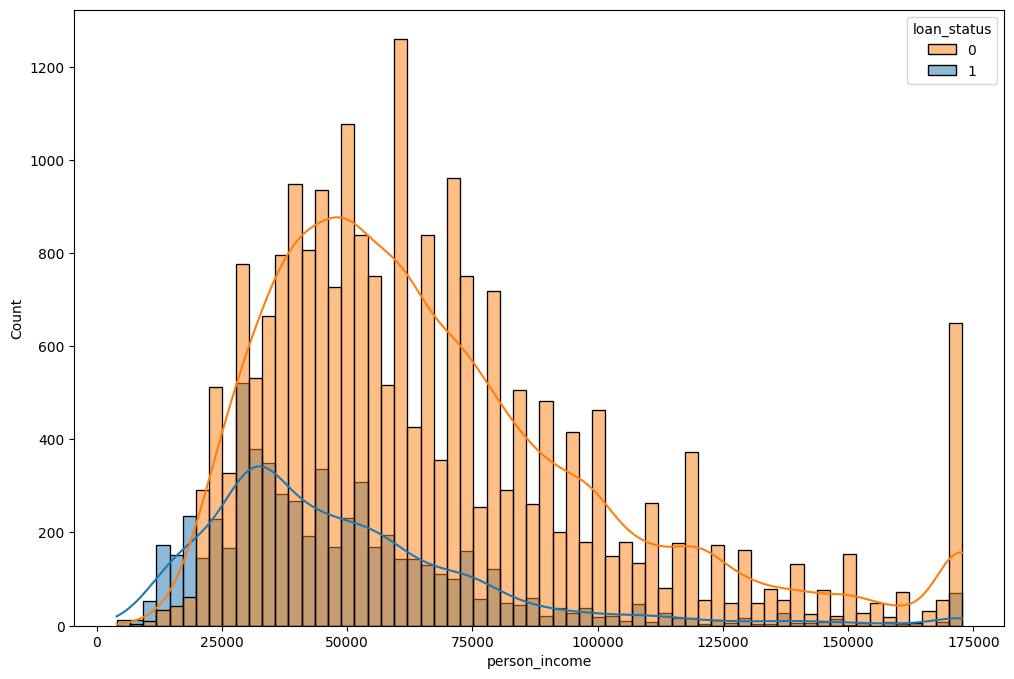

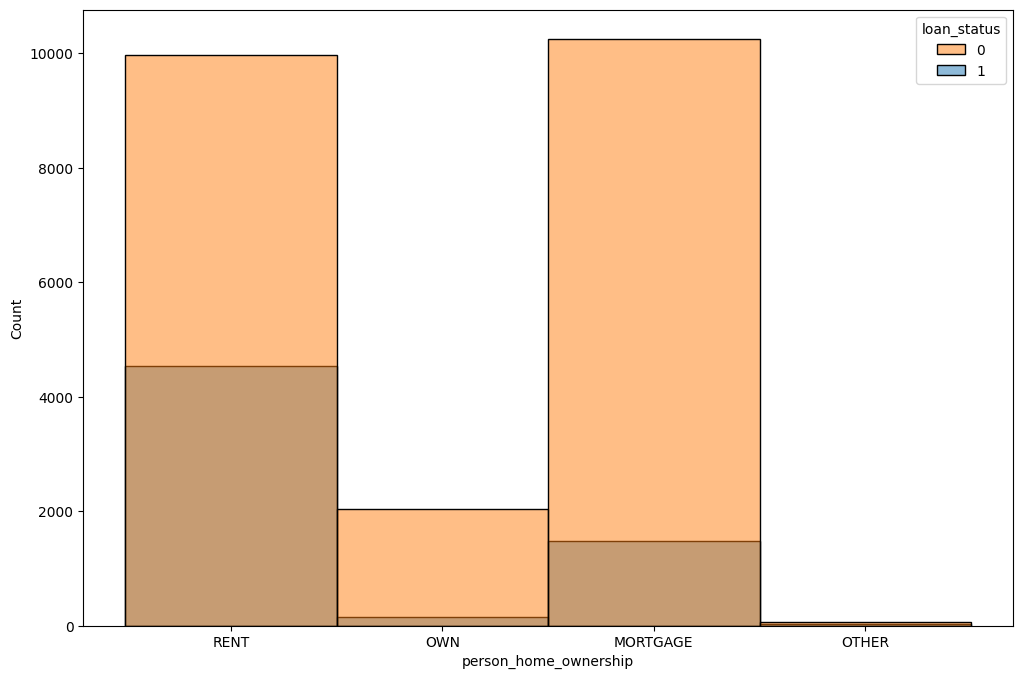

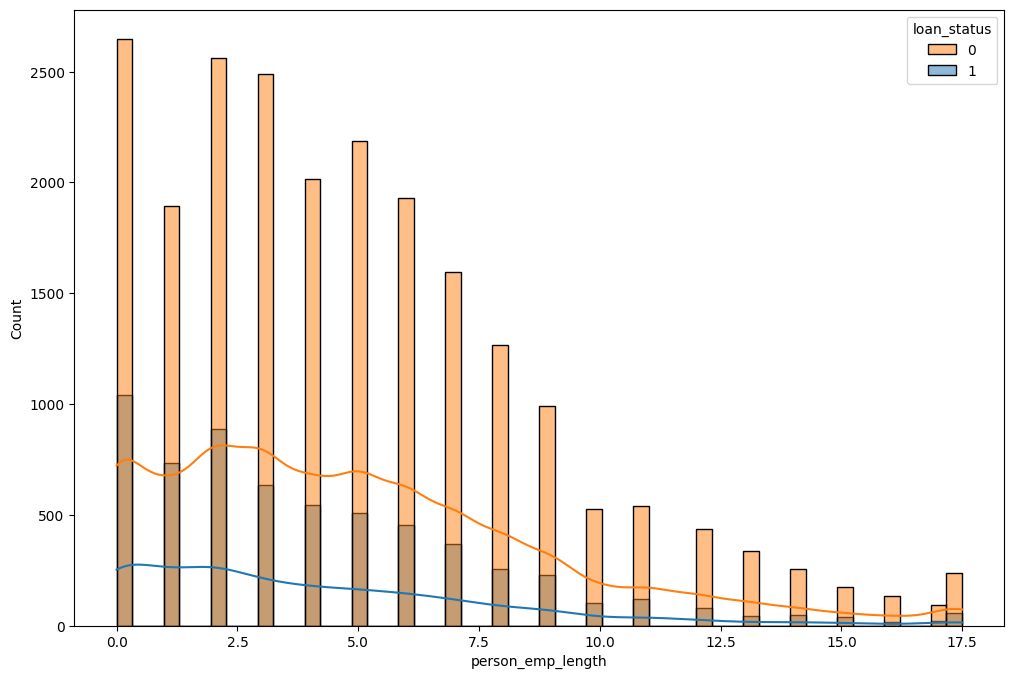

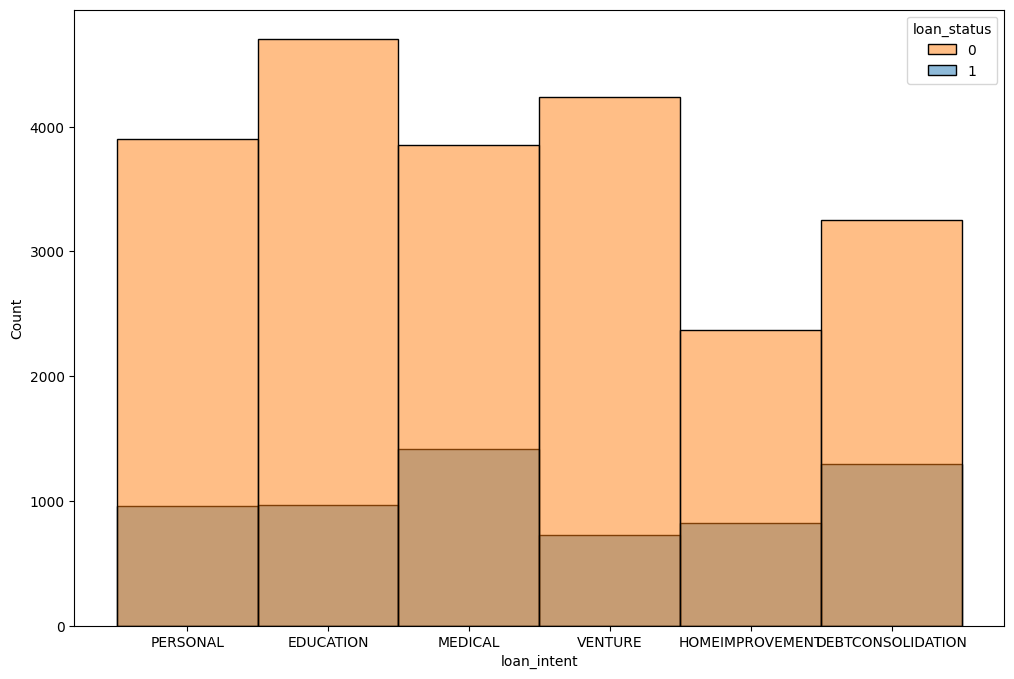

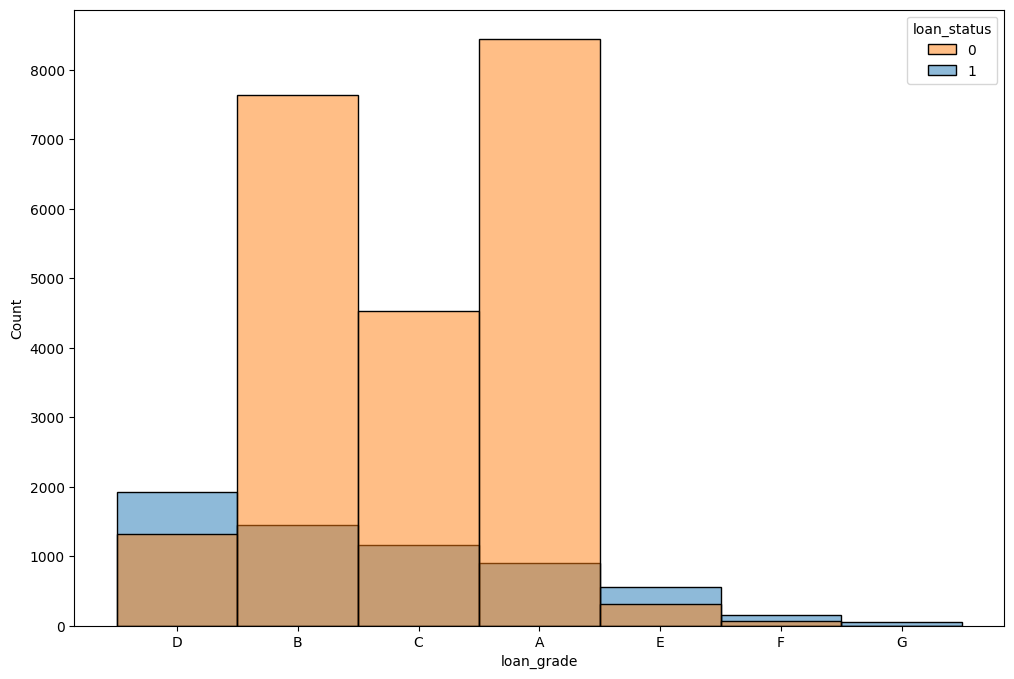

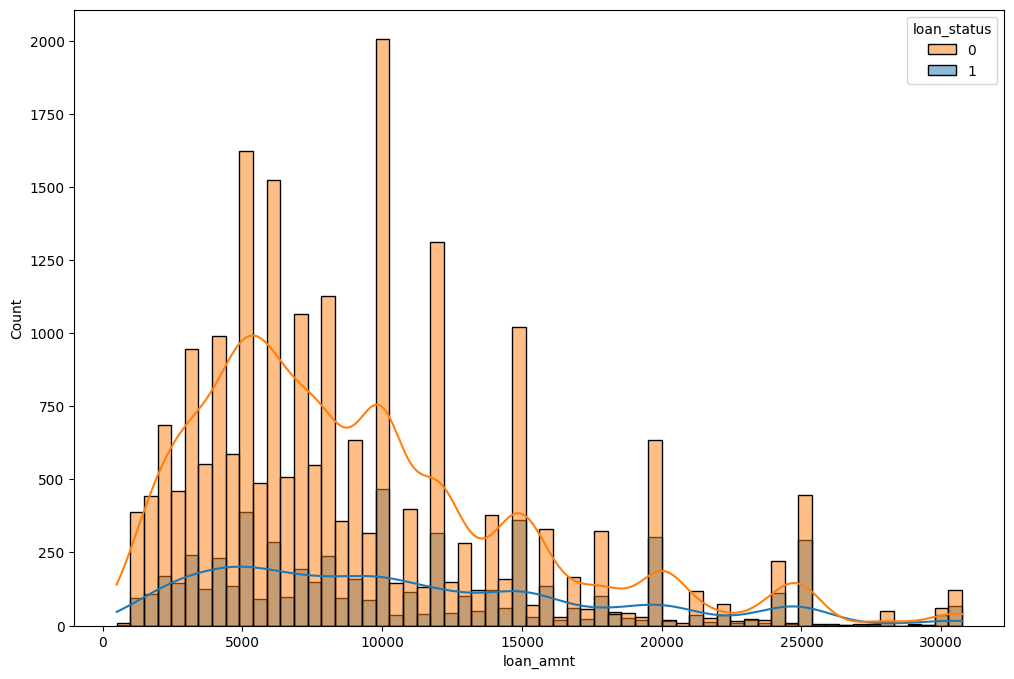

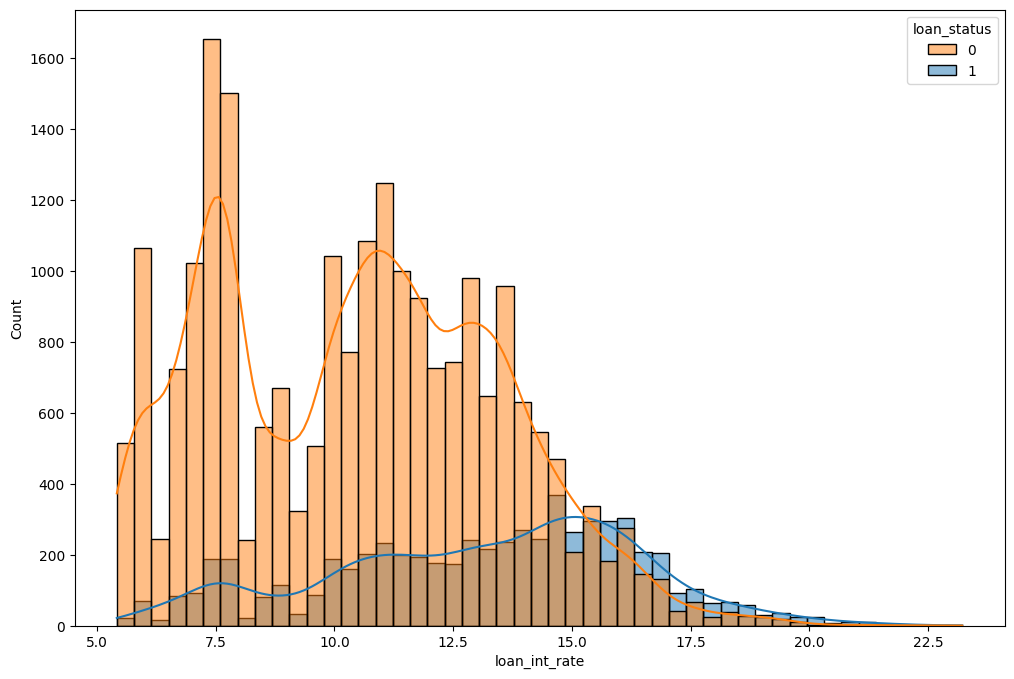

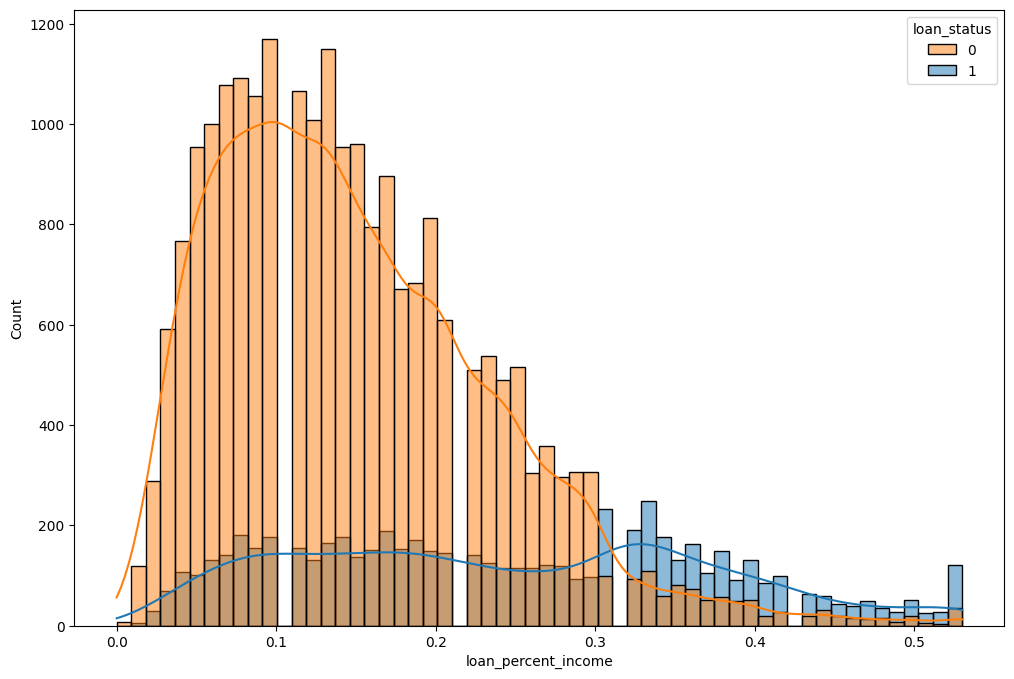

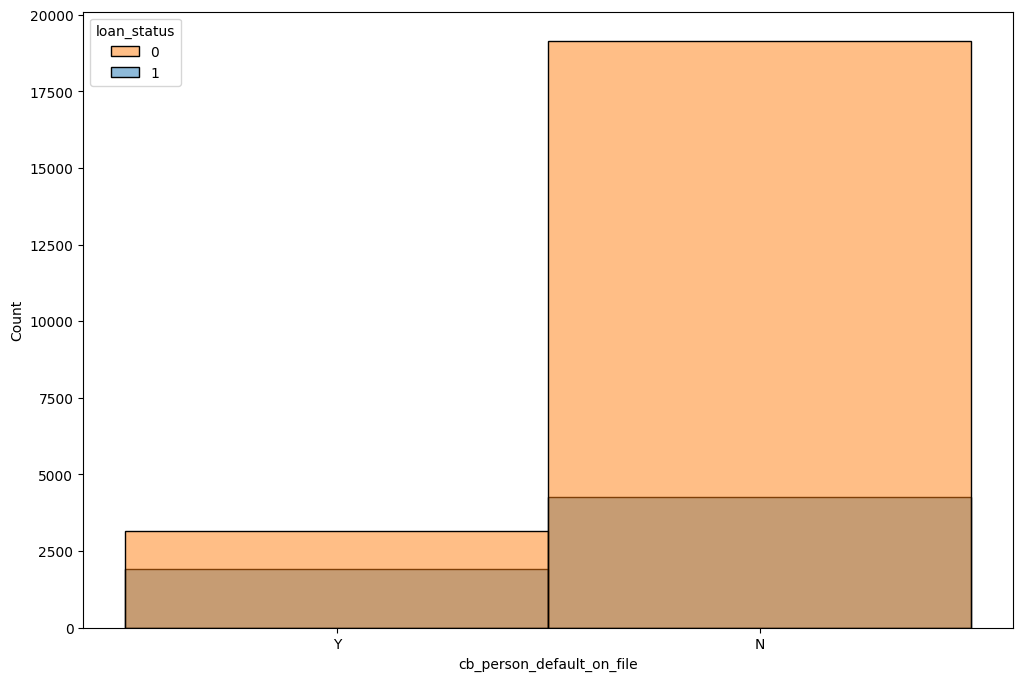

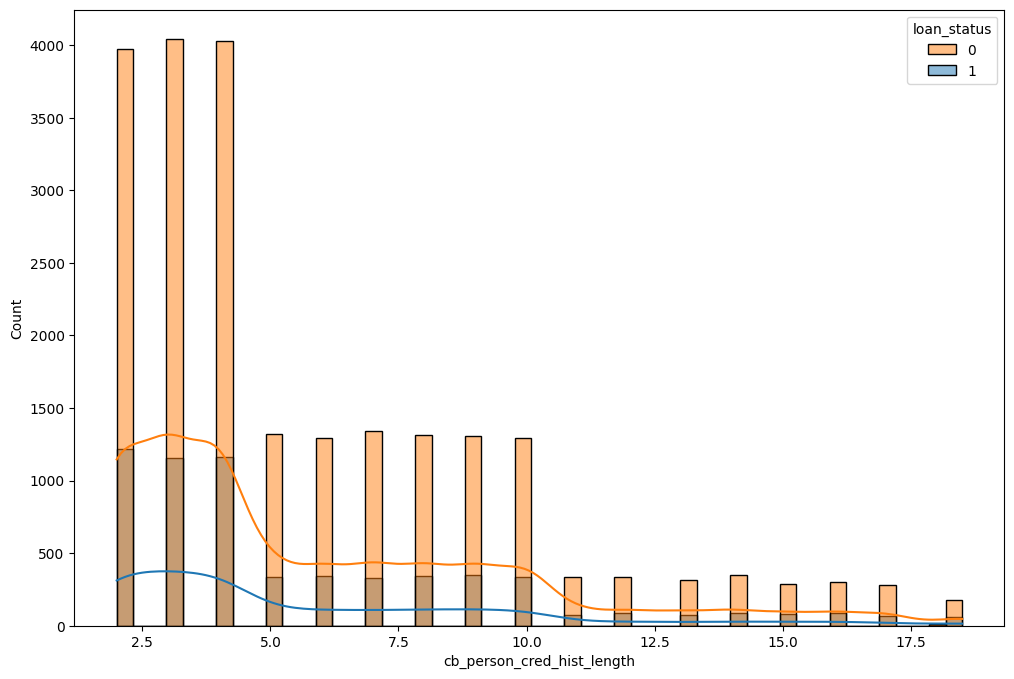

In [15]:
palette={0:"C1", 1:"C0"} #for better visualization
for col in df.columns:
    if col!= "loan_status":
        if col in selected_num_cols:
            kde_value= True
        else:
            kde_value=False
        plt.figure(figsize=(12,8))
        sns.histplot(data= df, x=col, hue="loan_status", kde=kde_value,palette=palette)
        plt.show()

### Data preprocessing

In [16]:
#one hot encoding categorical columns
def one_hot_encoder(dataframe, categorical_columns,drop_first=False):
    encoded_dataframe = pd.get_dummies(dataframe,columns=categorical_columns, drop_first=drop_first, dtype=int)
    return encoded_dataframe

In [17]:
selected_cat_cols

['cb_person_default_on_file',
 'loan_intent',
 'loan_status',
 'person_home_ownership',
 'loan_grade']

In [18]:
#we do not need loan_status
dfx = df.copy()
dfx = dfx.drop("loan_status",axis=1)

In [19]:
y= df["loan_status"]

### Handling highly correlated features

In [20]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(dfx)
X.shape

(28501, 10)

In [21]:
#one hot encode the categorical variables
X= one_hot_encoder(X,selected_cat_cols.remove("loan_status"),drop_first=True)

### Handling class imbalance

In [22]:
y.value_counts()

loan_status
0    22313
1     6188
Name: count, dtype: int64

In [23]:
smote = BorderlineSMOTE()
X,y = smote.fit_resample(X,y)

In [24]:
y.value_counts()

loan_status
1    22313
0    22313
Name: count, dtype: int64

In [31]:
X.shape

(44626, 21)

## Model Training and Evaluation

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7,stratify=y)

In [26]:
#scaling the features in the train and test set
scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_test = scaler.fit_transform(X_test)

In [32]:
sX_train.shape

(35700, 21)

### Model Training

In [33]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
def train_and_eval(model):
    model.fit(sX_train,y_train)
    y_pred = model.predict(sX_test)

    #get metrics for the model
    class_report = classification_report(y_test,y_pred)
    print(f"Classification report:/n{classification_report}")
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()

Classification report:/n<function classification_report at 0x000001B8C2A2F560>


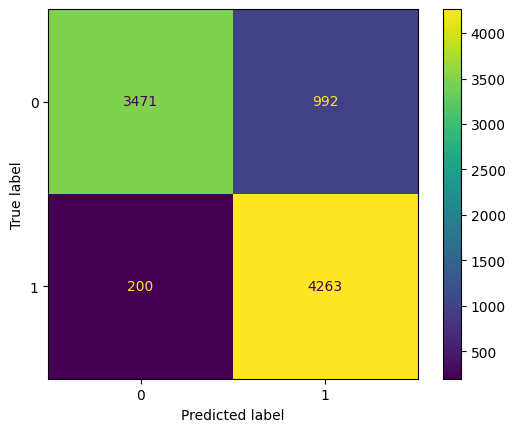

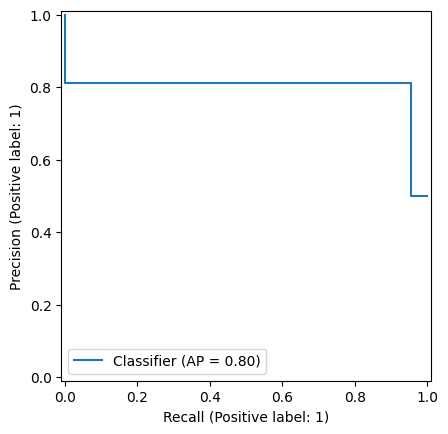

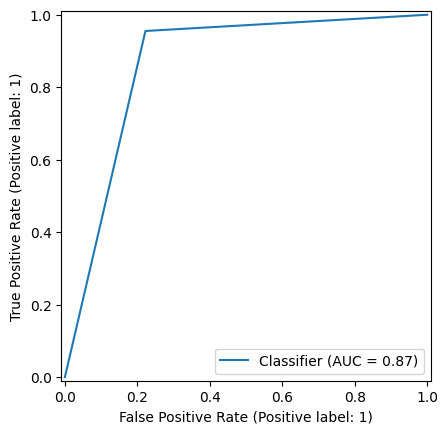

In [34]:
train_and_eval(LGBMClassifier(verbose=-1))

Classification report:/n<function classification_report at 0x000001B8C2A2F560>


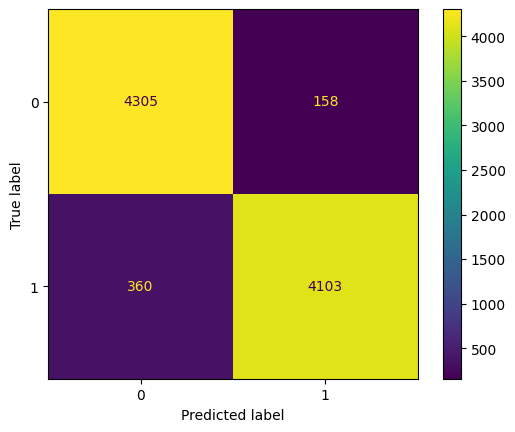

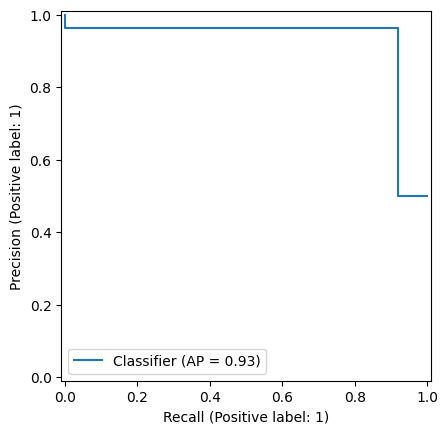

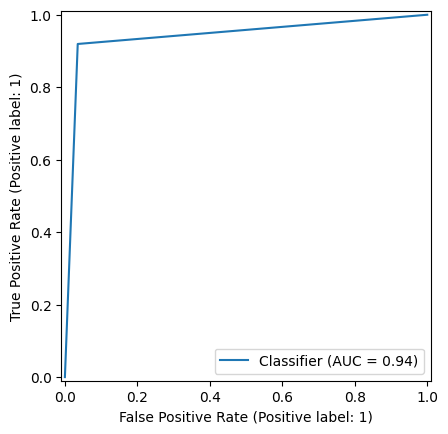

In [36]:
train_and_eval(RandomForestClassifier())

Classification report:/n<function classification_report at 0x000001B8C2A2F560>


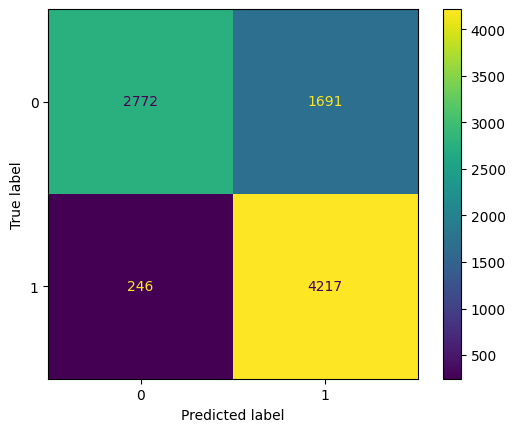

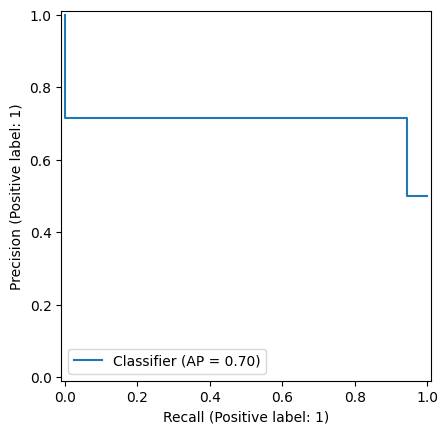

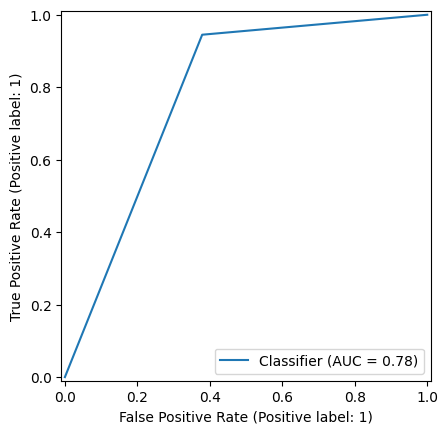

In [38]:
train_and_eval(XGBClassifier())

In [39]:
#checking model performance
model_perf = pd.DataFrame({'Model': models, 
                            'Accuracy': accuracy_scores, 
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)

In [40]:
model_perf

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,"(DecisionTreeClassifier(max_features='sqrt', r...",0.941967,0.942875,0.941967,0.941938,0.941967
1,LGBMClassifier(verbose=-1),0.866458,0.878373,0.866458,0.865398,0.866458
2,"XGBClassifier(base_score=None, booster=None, c...",0.782994,0.816133,0.782994,0.777153,0.782994


[LightGBM] [Info] Number of positive: 17850, number of negative: 17850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1575
[LightGBM] [Info] Number of data points in the train set: 35700, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14280, number of negative: 14280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 28560, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

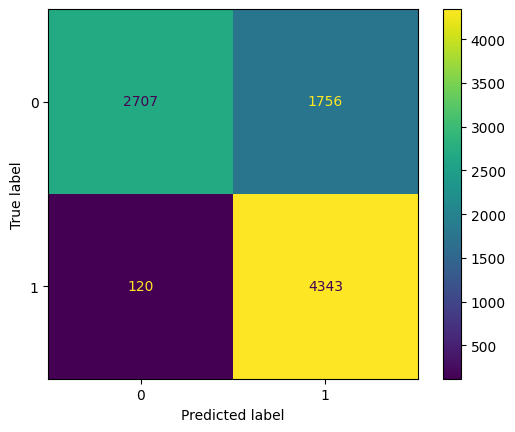

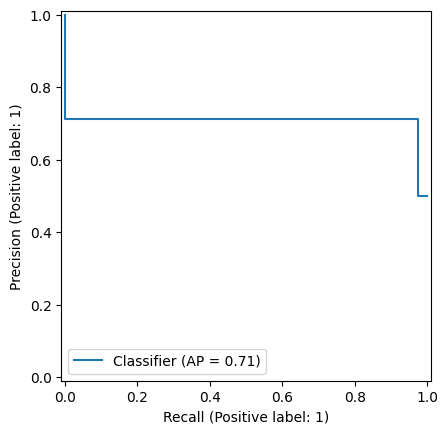

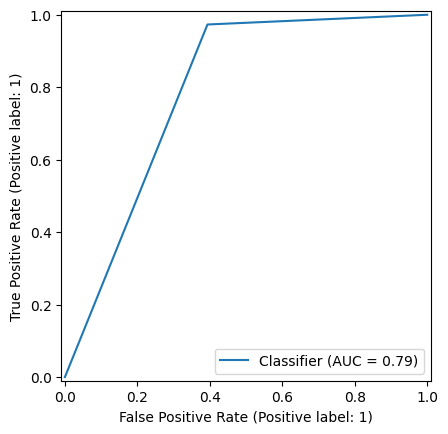

In [42]:
#an ensemble of these models may have better scores
from sklearn.ensemble import StackingClassifier

train_and_eval(StackingClassifier(estimators=[
    ('LGB',LGBMClassifier()),
    ('XGB',XGBClassifier()),
],final_estimator=RandomForestClassifier(),verbose=2))

In [43]:
model_perf = pd.DataFrame({'Model': models, 
                            'Accuracy': accuracy_scores, 
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)

In [44]:
model_perf

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,"(DecisionTreeClassifier(max_features='sqrt', r...",0.941967,0.942875,0.941967,0.941938,0.941967
1,LGBMClassifier(verbose=-1),0.866458,0.878373,0.866458,0.865398,0.866458
2,"StackingClassifier(estimators=[('LGB', LGBMCla...",0.789827,0.834818,0.789827,0.782522,0.789827
3,"XGBClassifier(base_score=None, booster=None, c...",0.782994,0.816133,0.782994,0.777153,0.782994
